In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.fftpack import fft
from scipy.signal import welch
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
sns.set_style("whitegrid")


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Funciones auxiliares para levantar data
def armarNombre(x):
    c = 'S' if x < 11 else 'P'
    x = (x-1)%10+1
    return str(c) + ("" if x == 10 else "0") + str(x)

def armarNombreArchivo(c, x):
    return "data/" + str(c) + ("" if x == 10 else "0") + str(x) + ".mat"

In [3]:
# Funcion auxiliar para pasar valores de frecuencia a bines
#    Delta < 4 Hz
#    4 Hz <= Theta < 8 Hz
#    8 Hz <= Alpha < 13 Hz
#    13 Hz <= Beta < 30 Hz
#    30 Hz <= Gamma < Nyquist

def nombre_banda(x):
    if x < 4:
        return 'Delta'
    elif x < 8:
        return 'Theta'
    elif x < 13:
        return 'Alpha'
    elif x < 30:
        return 'Beta'
    else:
        return 'Gamma'
    





def bin_de_frecuencia(x):
    if x < 4.:
        return 0
    elif x < 8.:
        return 1
    elif x < 13.:
        return 2
    elif x < 30.:
        return 3
    else:
        return 4
    
def agrupar_por_bines(potencias, frecuencias):
    res = np.zeros(5)
    for i in range(len(potencias)):
        res[bin_de_frecuencia(frecuencias[i])] += potencias[i]
    return res

In [4]:
pacientes_raw = {}
for f in os.listdir('./data'):
    fname = "./data/"+f 
    print(f[:-4] + ' -- cargado')
    pacientes_raw[f[:-4]] = (loadmat(fname)['data'])
    

P01 -- cargado
S02 -- cargado
S01 -- cargado
P02 -- cargado
S03 -- cargado
P03 -- cargado


In [5]:
welches = {}
acum_electrodo = np.array([0]*201)
normalizador = (lambda x : x/256)
vnormalizador = np.vectorize(normalizador)

for paciente in pacientes_raw:
    epochi = 0
    welches[paciente] = {}
    for epoch in pacientes_raw[paciente]:
        welches[paciente][epochi] = {}
        for electrodo in epoch:
            arr_electrodo = np.array(electrodo)
            acum_electrodo = np.sum([acum_electrodo,arr_electrodo],axis=0)
        acum_electrodo = vnormalizador(acum_electrodo)
        welches[paciente][epochi] = welch(acum_electrodo,fs= 201/1.54)
        epochi +=1


/usr/lib/python3/dist-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


In [6]:
bandas = {0:{},1:{}}
for paciente_k, paciente_v in welches.items():
    if paciente_k.startswith('P'):
        label = 0
    else:
        label = 1
    for epoch_k,epoch_v in paciente_v.items():
        for i in range(len(epoch_v[0])):
            try:
                bandas[label][nombre_banda(epoch_v[0][i])].append(epoch_v[1][i])
            except KeyError:
                bandas[label][nombre_banda(epoch_v[0][i])] = [epoch_v[1][i]]


In [7]:
def roc_banda(label,x,y,color):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5,random_state=0)


    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0],-1)
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0],-1)

    # print(X_test)


    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train) 



    y_score = neigh.predict_proba(X_test)
   # print(y_score[0])
    y_score = y_score[:,[1]].flatten()
    fpr,tpr,thresholds = roc_curve(y_test,y_score) 
    roc_auc =  auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color,
             lw=2, label='['+label+']ROC curve (area = %0.2f)' % roc_auc)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")




In [31]:
plt.clf()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
colores = ['darkorange','darkred','darkblue','darkgreen','pink','yellow','purple','black']
color = 0
data_roc = {}
for k,l in bandas.items():
    for label in l: 
        if not label in data_roc.keys():
            data_roc[label] = {'x' : [], 'y' : []}
        for v in l[label]:
            data_roc[label]['x']
            data_roc[label]['x'].append(v)
            data_roc[label]['y'].append(k)
            print(v)
for k,v in data_roc.items():
    col = colores[color]
    roc_banda(k,v['x'],v['y'],col)
    color+=1
plt.show()


2.32001456561e-14
3.23330010087e-14
1.75537589886e-14
1.08493685016e-15
2.85766407695e-16
7.03464879231e-15
1.59813462319e-14
5.12613434876e-14
3.80977635439e-14
1.42886961133e-14
1.51401681052e-14
6.08120484884e-15
5.61742178079e-15
4.61997461039e-15
2.63374610815e-15
4.09896292367e-15
2.6308581726e-15
1.4815998441e-15
6.52511539669e-16
4.31958647726e-17
8.62462162679e-19
1.71681363563e-17
8.70198475723e-18
7.1007803851e-18
1.17680118338e-19
5.70088607612e-19
2.80267979024e-15
5.85489386683e-16
9.11344966903e-15
1.48117024943e-14
3.82203750404e-16
1.30167883474e-14
1.08253434438e-14
4.07740134661e-15
4.41620706365e-15
3.67689165072e-15
1.28454392993e-14
6.68455124129e-15
6.81108427109e-15
1.74978701054e-14
6.10967763643e-15
5.71935116342e-15
2.40024235137e-15
2.90302689347e-16
2.19657597958e-16
5.50894221876e-17
7.91693349871e-18
8.56506603203e-18
5.53039434097e-18
4.40404744541e-18
1.12084016867e-18
3.24757895214e-19
2.79215852012e-15
4.56618464466e-15
5.46216222496e-15
7.41502731663

3.24624610114e-16
9.93019692376e-16
9.42174188886e-16
6.43009910115e-16
3.65639590689e-16
1.81356932234e-16
2.86540504347e-16
6.14376283295e-16
3.98253931812e-16
3.75804913264e-16
3.71197943811e-16
4.79409823146e-16
2.44634650355e-16
4.96739453398e-17
7.33911084403e-18
4.5250074076e-18
2.68650876351e-18
1.49634476011e-18
3.1056960091e-19
1.54824992944e-19
6.2345407564e-20
2.18147550358e-20
2.73487160842e-16
1.14293667983e-15
8.518838132e-16
4.10914126359e-16
5.66458469106e-16
6.60946960089e-16
1.20279074211e-15
9.24167514249e-16
1.45383479047e-15
1.96021586621e-15
2.02641871218e-15
1.60905965545e-15
1.61835398566e-15
9.1192140896e-16
1.15847919756e-15
8.55046176542e-16
5.14991119757e-16
3.30599295936e-16
7.21035864267e-17
6.27539924506e-18
2.62736431066e-18
1.30626388535e-18
1.31359793013e-18
6.77887453782e-19
8.93423476545e-20
1.96978380785e-20
1.38263554402e-16
1.23097277254e-15
8.89818419372e-16
7.83576193343e-17
1.32563944999e-15
2.523150827e-15
2.38573115867e-15
5.18485581698e-16


5.31583150133e-19
1.27611099165e-19
1.57889521766e-19
1.19742710625e-21
2.1323102109e-22
2.09537122512e-21
8.8228501131e-18
2.62822355276e-16
4.21724935097e-17
7.58624459185e-17
3.83182593999e-17
5.55794941681e-17
1.06496366099e-16
9.40445746003e-17
1.50815821727e-16
2.35749525485e-16
3.88996384096e-16
2.52208093082e-16
1.15720815463e-16
3.98180238952e-17
2.93067564935e-17
1.57741609727e-17
3.52364195478e-17
2.13479716274e-17
3.13911377017e-18
2.78028966219e-18
2.55844026907e-19
4.19081963055e-20
8.98968538291e-20
1.60895839857e-20
5.28752933176e-21
9.86773064945e-21
1.58078726632e-17
1.42596846511e-16
1.91130595499e-16
3.79850343817e-16
1.72015405638e-16
1.76362411169e-16
3.46777836141e-16
1.1806523421e-16
1.11030124175e-16
3.39105772111e-16
1.53358909836e-16
4.8986275e-17
8.43477115162e-17
2.59823476012e-16
3.85398774595e-16
1.89858970401e-16
2.59373607828e-17
9.47397174188e-18
1.48769118193e-17
4.95771860031e-18
8.59395642774e-19
1.14748131594e-19
4.55218726369e-20
7.90155760718e-20

3.61808292138e-17
8.34060169431e-17
1.12761293987e-16
1.98017314029e-17
1.348226938e-17
6.56564981787e-17
2.57114459282e-17
3.13045048576e-17
2.75907687905e-17
1.89631407842e-17
3.58996180374e-17
2.63666316048e-17
2.37813667236e-17
1.89502818992e-17
9.26148954616e-18
1.49492198405e-18
1.23637247448e-19
6.63615241781e-20
1.96517205809e-20
1.28017021694e-20
1.63094986247e-20
9.02264697841e-21
1.70558220953e-16
1.7065063137e-16
7.47998573538e-17
8.37255564104e-18
8.90277267254e-17
1.1725601649e-16
7.5098346794e-17
2.68280257272e-16
9.21784104554e-17
1.2464810799e-16
7.88559330481e-17
7.50771893949e-17
9.57570659971e-17
6.46453339433e-17
1.15704689995e-16
1.77752378646e-16
7.82827664952e-17
1.91752673893e-17
9.68171738637e-19
4.3341932027e-20
1.87472353411e-19
7.92728229114e-21
2.61581104832e-20
9.37461769193e-21
1.0282649726e-20
9.1151828593e-21
2.66284418643e-16
1.88562270159e-16
3.48270882662e-17
1.21677357621e-17
2.31969187027e-17
3.72424510996e-17
2.48266502698e-17
7.34395461681e-18
1

2.60459146371e-21
3.0132168872e-21
8.26602866391e-22
4.46257924239e-18
1.58442674459e-16
1.12132841191e-16
6.80809475453e-17
3.92645237355e-17
4.81365577123e-17
5.87396850188e-17
5.00647618189e-18
5.7925518351e-19
6.84537616763e-18
1.91864547149e-17
2.59891839219e-17
8.93542552609e-18
5.9712929354e-19
9.70605943124e-18
1.88057595399e-17
7.42165431213e-18
1.08884603856e-20
5.48108902234e-19
4.29804797287e-19
2.58964031424e-19
1.62836198134e-20
1.94148579395e-20
1.86852093044e-20
1.14815338542e-21
8.75226126333e-22
5.10774940822e-17
1.16460244332e-16
3.56153959264e-18
6.17008825796e-18
2.60819431823e-17
4.61181167984e-18
7.8102821156e-17
1.22203127051e-16
7.58293448035e-17
2.42169519406e-17
1.216376362e-17
2.22636558371e-17
6.64618882848e-18
2.17769330568e-18
5.7251857708e-18
1.5682647965e-18
2.00072191103e-19
5.40997385902e-19
2.11777176788e-18
4.4733218334e-19
6.23186143135e-20
5.73102922337e-20
1.56395423157e-20
3.35874997129e-21
2.93976350299e-21
1.12852533699e-21
4.25359030748e-18
6

1.30099374836e-16
8.36011114115e-17
2.56907172327e-17
4.7227436771e-18
2.19653469498e-18
2.66305663181e-18
3.29468064347e-19
6.72080162581e-19
2.61061178766e-19
4.19961264456e-20
7.63223111354e-16
7.66763179559e-16
7.6444946044e-16
6.03476179194e-16
1.57392092794e-16
6.23808717965e-16
7.1615896385e-16
3.54007786077e-15
1.89275546475e-15
6.69326809515e-17
9.58252763307e-17
1.42495179984e-15
2.23401703954e-15
1.15640788517e-16
1.68753615732e-16
4.03060960771e-17
8.9687367494e-17
9.83091087844e-17
1.00436046868e-17
7.14618219218e-18
1.27727880853e-17
5.58217951908e-18
6.14003667052e-20
7.01466842495e-19
5.24545959847e-20
5.37450886826e-20
2.63527399732e-17
2.13805631178e-16
6.06805565011e-16
2.62113547406e-16
2.52007732873e-16
1.50994604045e-15
1.43373931446e-15
6.31150343675e-16
7.25856345421e-16
1.22241386767e-15
4.77186891045e-16
5.91546135102e-17
2.04050340451e-16
7.01476128273e-17
1.85173190145e-16
4.59375369838e-16
6.45893518386e-17
1.88406007282e-16
2.91705800741e-17
2.28282613254e

4.85032206957e-16
3.59089885056e-16
1.07475316795e-16
6.35564404345e-16
1.16792643999e-15
1.10082702014e-15
7.26133316477e-16
5.58434769305e-16
5.3035143782e-16
1.20325714284e-16
7.55473873333e-17
1.1750073786e-17
1.41783174825e-17
3.29712861381e-18
9.38117711497e-19
1.23184742881e-18
9.35832316698e-19
2.42560058529e-20
2.41803505076e-20
1.20289790972e-16
6.31171350277e-16
2.74675081836e-15
3.89483183468e-15
2.46566680044e-15
1.94525789162e-15
5.35097023149e-16
9.75091301536e-16
4.94382313186e-16
8.98807213412e-16
1.56589888695e-15
2.25599906927e-15
4.04311395107e-16
1.1639994602e-16
5.11954130578e-17
6.0076993766e-16
3.17224257453e-16
1.86323962876e-17
6.80928777033e-18
4.35803723872e-18
1.0612272456e-18
1.38698298344e-18
2.35661884295e-18
1.05710272077e-19
1.75762468611e-19
3.32637846843e-20
3.28151549473e-16
9.27590809395e-16
4.40112511632e-16
8.38841783565e-16
9.32552671566e-16
7.86010610859e-16
8.73188322001e-17
4.77927867185e-16
8.50876506983e-17
1.72430076505e-15
1.7069001255e-1

2.75948235274e-16
1.81964499024e-16
3.4451704722e-16
1.22885675482e-15
9.3099806425e-16
1.14776083924e-16
6.11355778287e-17
1.25572079629e-16
3.43636379932e-16
3.27652773415e-16
1.6791293205e-16
5.53855058034e-17
7.07170302579e-18
3.10302495842e-18
3.03031245077e-18
4.63036311924e-19
6.38578645584e-21
5.87401065846e-19
1.05371383043e-19
1.34555066399e-20
2.38218651388e-16
1.76674248567e-16
2.0669152054e-16
1.00057299169e-15
4.4508133993e-16
4.34132920071e-16
2.87964927512e-16
6.30534169947e-16
1.79825067918e-15
1.71193238275e-16
1.00518815586e-15
4.69563706532e-16
2.86250661016e-16
3.02157835003e-16
4.96215304379e-18
7.63909238995e-17
6.76398382541e-17
4.77015353032e-17
1.92894637806e-17
9.75369804105e-18
2.26800709448e-19
8.60234855482e-19
4.8069726095e-19
2.32437778064e-19
6.2363762091e-21
6.11894218473e-20
6.59511332048e-16
2.03725893526e-16
1.24818183828e-16
1.56169243438e-15
9.75683827164e-16
1.74684880937e-16
2.86515659598e-16
6.95208114287e-17
4.83159099488e-17
4.00730476136e-16

1.12267834993e-17
3.47104957705e-17
1.68722672356e-16
1.16334606087e-16
3.91234223193e-17
2.13101488177e-18
4.63578161189e-19
2.39520306055e-19
1.28797454901e-19
1.7645211591e-20
1.96638894791e-19
1.06088458345e-19
1.17945590098e-20
2.14574526437e-17
6.49404745381e-17
6.10524885356e-16
4.83049429029e-16
9.90383427172e-16
1.71418119999e-15
1.00160943399e-15
9.51293901697e-16
1.64055016722e-15
6.48108719743e-16
1.52121159951e-16
3.32416549767e-16
5.73484957412e-16
5.40861135607e-16
1.7617921479e-16
8.84037132702e-17
3.99871696137e-18
2.91739084193e-17
2.19712073072e-17
4.5158683219e-18
6.69934028837e-19
6.60448821349e-19
6.803412614e-20
5.96384871961e-20
8.11379014765e-20
1.78633029306e-20
3.31717749211e-16
4.32855538426e-17
2.98136654429e-16
4.77775134259e-16
1.35806974471e-16
1.57791493992e-16
1.44755785492e-16
6.61704514436e-17
6.09458828665e-17
6.27914811982e-16
7.95321568515e-16
2.46120536259e-17
2.57843033743e-16
1.05494919118e-16
4.23932534315e-16
5.44323415171e-16
1.10426102839e-

KeyboardInterrupt: 

In [12]:
welches = {}
acum_electrodo = np.array([0]*201)
normalizador = (lambda x : x/256)
vnormalizador = np.vectorize(normalizador)

for paciente in pacientes_raw:
    epochi = 0
    welches[paciente] = {}
    for epoch in pacientes_raw[paciente]:
        welches[paciente][epochi] = {}
        for electrodo in epoch:
            arr_electrodo = np.array(electrodo)
            acum_electrodo = np.sum([acum_electrodo,arr_electrodo],axis=0)
        acum_electrodo = vnormalizador(acum_electrodo)
        welches[paciente][epochi] = welch(acum_electrodo,fs= 201/1.54)
        epochi +=1
        

        

201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201


/usr/lib/python3/dist-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201


201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101


201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101


201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101
201
101


In [45]:
bandas_normalizadas={}
        
for paciente,epochs in welches.items():
    if paciente.startswith('P'):
        tag = 0
    else:
        tag = 1
    for epochn,w in epochs.items():
        poder_por_frecuencia = {}
        for x in w:
            banda = nombre_banda(x[0])
            if banda in poder_por_frecuencia.keys():
                poder_por_frecuencia[banda] += x[1]
            else:
                poder_por_frecuencia[banda] = x[1]
        suma = 0
        for banda,poder in poder_por_frecuencia.items():
            suma += poder
        
        for banda,poder in poder_por_frecuencia.items():
            poder_normalizado = poder/suma
            poder_por_frecuencia[banda] = poder_normalizado
            
            if banda in bandas_normalizadas.keys():
                bandas_normalizadas[banda].append([poder_normalizado,tag])
            else:
                bandas_normalizadas[banda] = [poder_normalizado,tag]




In [27]:
bandas_normalizadas={}

for paciente_k, paciente_v in welches.items():
    if paciente_k.startswith('P'):
        label = 0
    else:
        label = 1
    for epoch_k,epoch_v in paciente_v.items():
        poder_por_banda = {}
        for i in range(len(epoch_v[0])):
            try:
                poder_por_banda[nombre_banda(epoch_v[0][i])]+=epoch_v[1][i]
            except KeyError:
                poder_por_banda[nombre_banda(epoch_v[0][i])]=epoch_v[1][i]

        suma = 0
        for banda,poder in poder_por_banda.items():
            suma += poder
        for banda,poder in poder_por_banda.items():
            poder_normalizado = poder/suma
            poder_por_banda[banda] = poder_normalizado
       
            try:
                bandas_normalizadas[banda].append([poder_normalizado,label])

            except KeyError:
                bandas_normalizadas[banda] = [[poder_normalizado,tag]]      



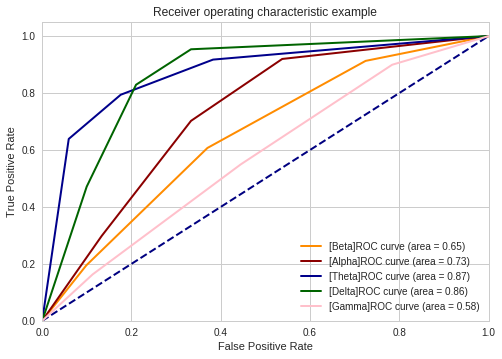

4154


In [44]:
plt.clf()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
colores = ['darkorange','darkred','darkblue','darkgreen','pink','yellow','purple','black']
color = 0
data_roc = {}
for banda,datos in bandas_normalizadas.items():
    for dato in datos:
        potencia_normalizada = dato[0]
        label = dato[1]
        if not banda in data_roc.keys():
            data_roc[banda] = {'x' : [], 'y' : []}
 
        data_roc[banda]['x'].append(potencia_normalizada)
        data_roc[banda]['y'].append(label)
            
for k,v in data_roc.items():
    col = colores[color]
    color += 1
    roc_banda(k,v['x'],v['y'],col)
plt.show()